# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:

# import libraries
import os

from pyspark.sql import SparkSession;
from pyspark.sql.functions import isnan,count,when,col, concat, desc, explode, lit, min, max, split, udf, isnull;
from pyspark.sql.types import IntegerType;

from pyspark.ml.feature import RegexTokenizer, CountVectorizer,IDF, StringIndexer,VectorAssembler, Normalizer, StandardScaler;
from pyspark.ml import Pipeline;
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier;
from pyspark.ml.evaluation import MulticlassClassificationEvaluator;

from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum

import re;
import datetime;
import matplotlib.pyplot as plt;
import pandas as pd;
import seaborn as sns;
import numpy as np;
from itertools import cycle, islice;

In [2]:
# create a Spark session
spark = SparkSession\
                    .builder\
                    .master('local')\
                    .appName("Sparkify")\
                    .getOrCreate();

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#load data "mini_sparkify_event_data.json"
df = spark.read.json('mini_sparkify_event_data.json');

#see top records in dataset
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [18]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [31]:
print(df.take(5));

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'), Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'), Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='Ba

In [32]:
#lets look at shema of data :
df.printSchema();

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [33]:
print((df.count(), len(df.columns)))

(286500, 18)


In [34]:
print("Number of  Rows in the dataframe:{}".format(df.count()));
print("Number of  columns in the dataframe:{}".format(len(df.columns)));
print("columns Present in data set in the dataframe{}".format(df.columns));

Number of  Rows in the dataframe:286500
Number of  columns in the dataframe:18
columns Present in data set in the dataframe['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']


In [35]:
#discribing all the columns in dataframe
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
artist,228108,551.0852017937219,1217.7693079161374,!!!,ÃÂlafur Arnalds
auth,286500,None,None,Cancelled,Logged Out
firstName,278154,None,None,Adelaida,Zyonna
gender,278154,None,None,F,M
itemInSession,286500,114.41421291448516,129.76726201140994,0,1321
lastName,278154,None,None,Adams,Wright
length,228108,249.1171819778458,99.23517921058361,0.78322,3024.66567
level,286500,None,None,free,paid
location,278154,None,None,"Albany, OR","Winston-Salem, NC"


First, we clean our dataset, checking for invalid or missing data. For example, records without userids or session id's

In [36]:
df.toPandas().isnull().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

In [37]:
df.toPandas().isnull().sum().sum()

225252

In [4]:
# drop NAs there is no null values in columns in userId and sessionId
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [5]:
# inspect 'userId' column
df.select('userId').dropDuplicates().sort('userId').show(10)


+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



In [5]:
# drop empty strings
df = df.filter(df['userId'] != '')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## Some preliminary Exploratory Data analysis

##### Let's look into Page Feature which has "Cancellation Confirmation" variable from which we can derive our Target Variable ie. churn or not?

In [21]:
df.select('page','UserId').groupby('page').agg({'page':'count'}).select('page','count(page)').show()

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|              Cancel|         52|
|    Submit Downgrade|         63|
|         Thumbs Down|       2546|
|                Home|      10082|
|           Downgrade|       2055|
|         Roll Advert|       3933|
|              Logout|       3226|
|       Save Settings|        310|
|Cancellation Conf...|         52|
|               About|        495|
|            Settings|       1514|
|     Add to Playlist|       6526|
|          Add Friend|       4277|
|            NextSong|     228108|
|           Thumbs Up|      12551|
|                Help|       1454|
|             Upgrade|        499|
|               Error|        252|
|      Submit Upgrade|        159|
+--------------------+-----------+



## Observations:

This gives us already a good indicator for the churn definition: we could define churned users as those users who have visited the ‘Cancelation Confirmation’ page. Further, we could take the ‘Submit Downgrade’ column into account.

### Define Churn

Let’s start with the definition of an indicator if a user has visited the ‘Cancel Confirmation’ page:

Next, let us define a column churn by using a user defined function which flags all churned user with a 1 and 0 oterwise:

In [6]:
# Churn is a label for user who cancelled
# Define a flag function
flag_cancelation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# apply to the dataframe
df = df.withColumn("churn", flag_cancelation_event("page"))
#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df = df.withColumn("churn", Fsum("churn").over(windowval))

##### I'm creating a temp view from dataframe df,so that we can use sparkSQL for quick easy analysis by using sql queries.

In [7]:
#creating a temp view from dataframe df,so that we can use sparkSQL for quick easy analysis
df.createOrReplaceTempView('data');


###### Let's check how many churned and non-churned user we have in the dataset:

In [33]:
spark.sql("""
          SELECT
              churn,
              count(distinct userId)
            FROM
                data
            GROUP BY
                churn
            """).show()

+-----+----------------------+
|churn|count(DISTINCT userId)|
+-----+----------------------+
|    0|                   173|
|    1|                    52|
+-----+----------------------+



In [34]:
spark.sql('SELECT COUNT(DISTINCT userId) As count_of_Uniq_users  FROM data').show()

+-------------------+
|count_of_Uniq_users|
+-------------------+
|                225|
+-------------------+



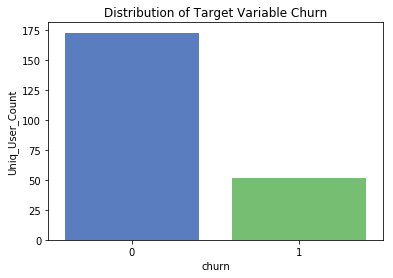

In [35]:
df_vs_class=spark.sql("select churn,count(distinct(userId)) as Uniq_User_Count from data group by churn").toPandas()
plt.title("Distribution of Target Variable Churn")
sns.barplot(x="churn", y="Uniq_User_Count", data=df_vs_class,palette="muted")
plt.show();



# Taking the bonus task challange and checking whether "Submit Downgrade" will qualify to define Churn or not.

In [8]:
user_with_downgrade = spark.sql("select distinct userId from data where page = 'Submit Downgrade'")
user_with_downgrade = user_with_downgrade.toPandas()['userId'].values

In [9]:
has_sub_downgrade = udf(lambda user: 1 if user in user_with_downgrade else 0, IntegerType())
spark.udf.register('has_sub_downgrade', has_sub_downgrade)

<function __main__.<lambda>(user)>

In [10]:
data_1 = spark.sql("""
    SELECT * ,
        has_sub_downgrade(userId) as hasSubDowngrade
    FROM
        data
    """)

In [11]:
data_1.createOrReplaceTempView('data_1')

In [12]:
feature_downgrade = spark.sql("""
    SELECT
        DISTINCT userId,
        hasSubDowngrade,
        churn
    FROM
        data_1
    """)

In [41]:
feature_downgrade.createOrReplaceTempView('feature_downgrade_tbl')

In [42]:
spark.sql("select churn, sum(hasSubDowngrade)/count(distinct userId) As difference_in_submitting_downgrade from feature_downgrade_tbl group by churn").show()

+-----+----------------------------------+
|churn|difference_in_submitting_downgrade|
+-----+----------------------------------+
|    0|               0.23121387283236994|
|    1|               0.17307692307692307|
+-----+----------------------------------+




As we can see, there is basically no (major) difference in submitting a downgrade for churned and non-churned users. Interestingly, non-churned users are submitting downgrades more frequently. As a result, we plan to not to include the submit downgrade indicator as a feature.


##### By taking above statement in to the consideration,  we used only "Cancellation Confirmation" as feature to define Churn but not "submit downgrade"

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

###### For now we will derive feature which we think mostly good predicter of target ie. churn and will use those feature to test/train our model

### Feature 1:  Number of Added Friends

I am Assuming that the non-churn people add their friends frequenty. 

Lets check whether my assumption is correct or not

In [12]:
spark.sql("SELECT churn,count(1)/count(DISTINCT userId) AS Freinds FROM data_1\
            WHERE page = 'Add Friend' GROUP BY churn").show();
Freinds_vs=spark.sql("SELECT churn,count(1)/count(DISTINCT userId) AS Freinds FROM data_1\
            WHERE page = 'Add Friend' GROUP BY churn").toPandas();

feature_friends = spark.sql("SELECT DISTINCT(userId),count(1) AS Friends FROM data_1\
        WHERE page = 'Add Friend' GROUP BY userId");

feature_friends.createOrReplaceTempView('feature_friends');

+-----+------------------+
|churn|           Freinds|
+-----+------------------+
|    0| 22.47530864197531|
|    1|14.454545454545455|
+-----+------------------+



### Visualization : Feature Add_Friends

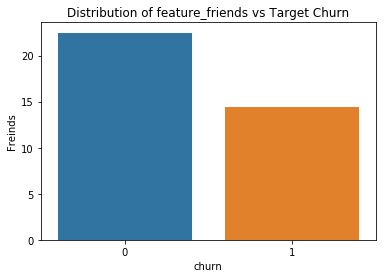

In [99]:
plt.title("Distribution of feature_friends vs Target Churn");
sns.barplot(x="churn", y="Freinds", data=Freinds_vs);
plt.show();

We can see that non-churned users indeed add friends more often. Hence we include that as a feature:

### Feature 2:  Playlist

users who add more Playlist mostly not going to churn or they are going to churn? lets check?

In [13]:
spark.sql("SELECT churn,count(1)/count(DISTINCT userId)  AS Playlist FROM data_1\
                        WHERE page ='Add to Playlist' GROUP BY churn").show();

Playlist_vs=spark.sql("SELECT churn,count(1)/count(DISTINCT userId)  AS Playlist FROM data_1\
                        WHERE page ='Add to Playlist' GROUP BY churn").toPandas();

feature_Playlist=spark.sql("SELECT DISTINCT(userId),count(1)/count(DISTINCT userId) AS Playlist FROM data_1\
            WHERE page ='Add to Playlist' GROUP BY userId");


feature_Playlist.createOrReplaceTempView('feature_add_Playlist');

+-----+-----------------+
|churn|         Playlist|
+-----+-----------------+
|    0|33.26060606060606|
|    1|            20.76|
+-----+-----------------+



## Visualization plot: feature_Playlist

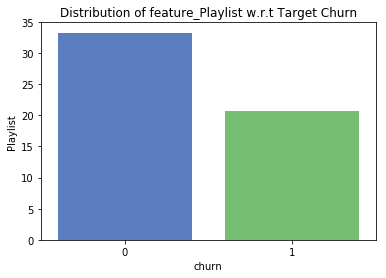

In [51]:
plt.title("Distribution of feature_Playlist w.r.t Target Churn");
sns.barplot(x="churn", y="Playlist", data=Playlist_vs,palette="muted");
plt.show();


Our assumption was right if he has less playlist in his app then is about to churn . we will consider this feature in our model.

### Feature 3:  Usage_time 


We can see here usage time is more for user who will not going to churn vs who is going to chur . so check and add this feature in our model.

In [14]:
spark.sql("SELECT churn,\
          sum(length)/count(distinct userId)  \
          AS usageTime FROM data_1\
          WHERE page = 'NextSong' GROUP BY  churn").show();

usage_time_vs=spark.sql("SELECT churn,sum(length)/count(distinct userId) AS usageTime FROM data_1\
                        WHERE page = 'NextSong' GROUP BY  churn").toPandas();

feature_usage_time=spark.sql("SELECT DISTINCT(userId),sum(nvl(length, 0)) AS usageTime FROM data_1\
                              WHERE page = 'NextSong' GROUP BY userId");

feature_usage_time.createOrReplaceTempView('feature_usage_time');

+-----+------------------+
|churn|         usageTime|
+-----+------------------+
|    0|276166.93746780336|
|    1| 174014.2685513462|
+-----+------------------+



### Visualization: for feature usage_time

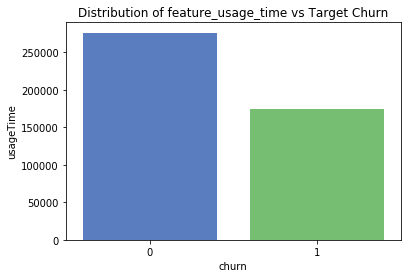

In [53]:

plt.title("Distribution of feature_usage_time vs Target Churn");
sns.barplot(x="churn", y="usageTime", data=usage_time_vs,palette="muted");
plt.show();


### Feature 4: number of Downgrades


this feature also looks singficant we will add this in our model.

In [15]:
spark.sql("SELECT churn,count(1)/count(DISTINCT userId) \
    AS Downgrade FROM data_1 \
    WHERE page ='Downgrade' GROUP BY churn").show();
Downgrade_vs=spark.sql("SELECT churn,count(1)/count(DISTINCT userId) \
    AS Downgrade FROM data_1 \
    WHERE page ='Downgrade' GROUP BY churn").toPandas();

feature_Downgrade=spark.sql("SELECT DISTINCT(userId),count(1)/count(DISTINCT userId) AS Downgrade FROM data_1\
                        WHERE page ='Downgrade' GROUP BY userId");

feature_Downgrade.createOrReplaceTempView('feature_Downgrade');

+-----+------------------+
|churn|         Downgrade|
+-----+------------------+
|    0|14.436974789915967|
|    1| 9.628571428571428|
+-----+------------------+



### Visualization :  For feature Downgrade

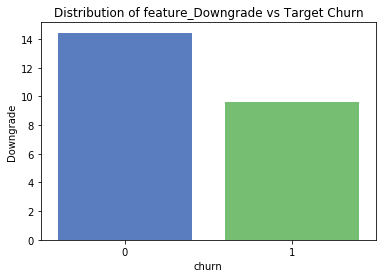

In [55]:
plt.title("Distribution of feature_Downgrade vs Target Churn");
sns.barplot(x="churn", y="Downgrade", data=Downgrade_vs,palette="muted");
plt.show();

### Feature 5: Gender

Let's see how Gender impacting the churn.

In [16]:
spark.sql("SELECT churn,gender,count(1)/count(DISTINCT userId) gender_cnt FROM data_1 GROUP BY churn,gender").show();

gender_vs=spark.sql("SELECT churn,gender,count(1)/count(DISTINCT userId) gender_cnt FROM data_1 GROUP BY churn,gender").toPandas();

feature_gender = spark.sql("SELECT DISTINCT(userId),CASE when gender='M' then 1 \
                            when gender='F' then 0 else 2 END AS gender_dummy FROM data_1");
 
feature_gender.createOrReplaceTempView('feature_gender');
spark.sql("select gender_dummy,count(DISTINCT(userId)) from feature_gender group by gender_dummy").show()

+-----+------+------------------+
|churn|gender|        gender_cnt|
+-----+------+------------------+
|    0|     F|1612.0238095238096|
|    1|     M|             803.0|
|    1|     F|             958.4|
|    0|     M|1099.7752808988764|
+-----+------+------------------+

+------------+----------------------+
|gender_dummy|count(DISTINCT userId)|
+------------+----------------------+
|           1|                   121|
|           0|                   104|
+------------+----------------------+



### Visualization : For feature gender

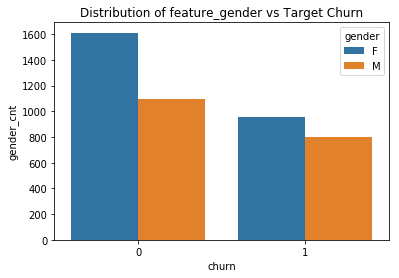

In [59]:
plt.title("Distribution of feature_gender vs Target Churn");
sns.barplot(x="churn", y="gender_cnt", hue='gender',data=gender_vs);
plt.show();

### Feature 6: avg sessions

In case if customer using most of the times then,  is not goint to churn so we will add this feature in our model

In [17]:
spark.sql("SELECT churn,avg(distinct sessionId) \
    AS avg_no_sessions FROM data_1 group by churn").show();

avg_no_sessions_vs=spark.sql("SELECT churn,avg(distinct sessionId) AS avg_no_sessions \
                             FROM data_1 group by churn").toPandas();

feature_avg_no_sessions = spark.sql("SELECT DISTINCT(userId),avg(distinct sessionId) AS avg_no_sessions FROM data_1 group\
                            by userId");

feature_avg_no_sessions.createOrReplaceTempView('feature_avg_no_sessions');

+-----+------------------+
|churn|   avg_no_sessions|
+-----+------------------+
|    0|1198.2928909952607|
|    1| 559.4786324786324|
+-----+------------------+




### Visualization : For feature avg_no_sessions

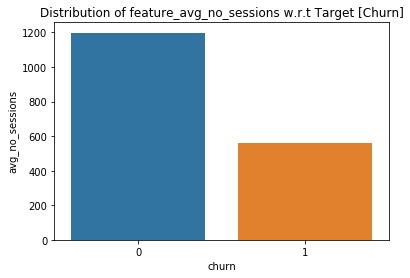

In [61]:
plt.title("Distribution of feature_avg_no_sessions w.r.t Target [Churn]");
sns.barplot(x="churn", y="avg_no_sessions", data=avg_no_sessions_vs);
plt.show();

### Feature 7: Level Paid

Paid users won't prefer to churn, Let's see

In [18]:
spark.sql("SELECT churn,count(1)/count(DISTINCT userId) AS level_paid \
    FROM data_1 WHERE level = 'paid' \
    GROUP BY churn").show();

level_paid_vs=spark.sql("SELECT churn,count(1)/count(DISTINCT userId) AS level_paid \
    FROM data_1 WHERE level = 'paid' GROUP BY churn").toPandas();

feature_level_paid = spark.sql("SELECT DISTINCT(userId),count(1)/count(DISTINCT userId) AS level_paid FROM data_1\
                    WHERE level = 'paid' GROUP BY userId");

feature_level_paid.createOrReplaceTempView('feature_level_paid');

+-----+------------------+
|churn|        level_paid|
+-----+------------------+
|    0|1472.5348837209303|
|    1| 902.1111111111111|
+-----+------------------+




### Visualization :  For feature level_paid

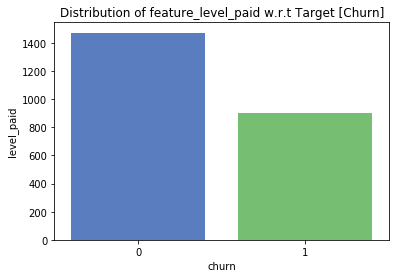

In [64]:
plt.title("Distribution of feature_level_paid w.r.t Target [Churn]");
sns.barplot(x="churn", y="level_paid", data=level_paid_vs,palette="muted");
plt.show();

### Feature 8: Level Free

In [19]:
spark.sql("SELECT churn,count(1)/count(DISTINCT userId) AS level_free FROM data_1 WHERE level = 'free' GROUP BY churn").show();

level_free_vs=spark.sql("SELECT churn,count(1)/count(DISTINCT userId) AS level_free FROM data_1 WHERE level = 'free' GROUP BY churn").toPandas();

feature_level_free = spark.sql("SELECT DISTINCT(userId),count(1)/count(DISTINCT userId) AS level_free FROM data_1\
                    WHERE level = 'free' GROUP BY userId");

feature_level_free.createOrReplaceTempView('feature_level_free');

+-----+------------------+
|churn|        level_free|
+-----+------------------+
|    0| 290.8255033557047|
|    1|269.30434782608694|
+-----+------------------+



### Visualization : For feature level_free

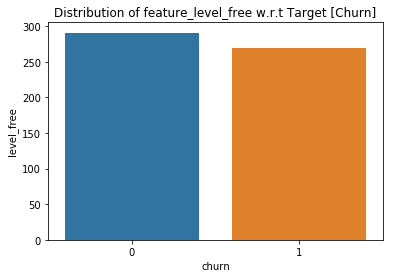

In [70]:
plt.title("Distribution of feature_level_free w.r.t Target [Churn]");
sns.barplot(x="churn", y="level_free", data=level_free_vs);
plt.show();

### Feature 9: Thumps up

In [20]:
spark.sql("SELECT churn,count(1)/count(DISTINCT userId) as n_ThumpsUp \
    FROM data_1 WHERE page = 'Thumbs Up' GROUP BY churn").show()

feature_thumps_up_vs= spark.sql("SELECT churn, count(1)/count(DISTINCT userId) as n_ThumpsUp \
    FROM data_1 WHERE page = 'Thumbs Up' GROUP BY churn").toPandas()

feature_thumps_up = spark.sql("SELECT DISTINCT(userId),count(1)/count(DISTINCT userId) AS n_Thumpsup \
    FROM data_1 WHERE page = 'Thumbs Up' GROUP BY userId");



feature_thumps_up.createOrReplaceTempView('feature_thumps_up');

+-----+-----------------+
|churn|       n_ThumpsUp|
+-----+-----------------+
|    0|62.89411764705882|
|    1|            37.18|
+-----+-----------------+



### Visualization: For Thumbs Up

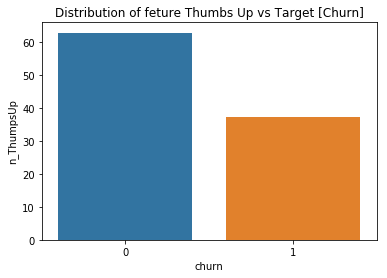

In [108]:
plt.title("Distribution of feture Thumbs Up vs Target [Churn]");
sns.barplot(x="churn", y="n_ThumpsUp", data=feature_thumps_up_vs);
plt.show();

### Feature 10: request_help

Users who request for help are churning less compared to user who does not ask for help that makes sense so will consider this feature in our model.

In [21]:
spark.sql("SELECT churn,count(1)/count(DISTINCT userId) As help FROM data_1 WHERE page ='Help' GROUP BY churn").show();
help_vs=spark.sql("SELECT churn,count(1)/count(DISTINCT userId) As help FROM data_1 WHERE page ='Help' GROUP BY churn").toPandas();
feature_help=spark.sql("SELECT DISTINCT(userId),count(1)/count(DISTINCT userId) AS help FROM data_1\
                        WHERE page ='Help' GROUP BY userId");

feature_help.createOrReplaceTempView('feature_help');

+-----+-----------------+
|churn|             help|
+-----+-----------------+
|    0|8.154362416107382|
|    1|5.558139534883721|
+-----+-----------------+



### Visualization: For feature_help

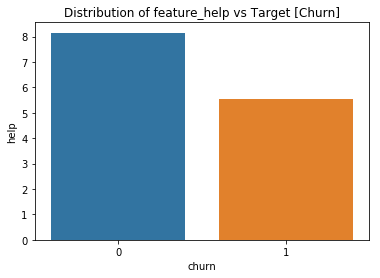

In [91]:

plt.title("Distribution of feature_help vs Target [Churn]");
sns.barplot(x="churn", y="help", data=help_vs);
plt.show();

## Let's create a new table with all the Features we considered by above exploration

In [22]:
feature_table = spark.sql("SELECT a.userId,b.Playlist,c.usageTime,\
                            d.Downgrade,e.help,f.friends,g.level_paid,k.n_Thumpsup,h.level_free,\
                            i.avg_no_sessions,j.gender_dummy,a.churn as label FROM data_1 as a\
                            LEFT OUTER JOIN feature_add_Playlist as b\
                            ON a.userId=b.userId \
                            LEFT OUTER JOIN feature_usage_time as c\
                            ON b.userId = c.userId\
                            LEFT OUTER JOIN feature_Downgrade as d\
                            ON c.userId=d.userId\
                            LEFT OUTER JOIN feature_help as e\
                            ON d.userId=e.userId\
                            LEFT OUTER JOIN feature_friends as f\
                            ON e.userId=f.userId\
                            LEFT OUTER JOIN feature_level_paid as g\
                            ON f.userId=g.userId\
                            LEFT OUTER JOIN feature_level_free as h\
                            ON g.userId=h.userId\
                            LEFT OUTER JOIN feature_avg_no_sessions as i\
                            ON h.userId=i.userId\
                            LEFT OUTER JOIN feature_gender j\
                            on i.userId=j.userId\
                            LEFT OUTER JOIN feature_thumps_up k\
                            on j.userId=k.userId");

feature_table.createOrReplaceTempView('feature_table')

#check distribution of class looks fine or not?
spark.sql("select label,count(distinct userId) as Class_dist from feature_table group by label").show()

+-----+----------+
|label|Class_dist|
+-----+----------+
|    0|       173|
|    1|        52|
+-----+----------+



In [24]:
feature_table.toPandas().isnull().sum()

userId                 0
Playlist             464
usageTime            464
Downgrade          17438
help               19079
friends            19079
level_paid         19079
n_Thumpsup         55387
level_free         55387
avg_no_sessions    55387
gender_dummy       55387
label                  0
dtype: int64

In [23]:
#check in case if any Null values will be present.
#impute them with zero(0) for all except gender because we it will wrong imputation so we will keep value as 2 for all null treating it differently in model.

selected_feature_table = spark.sql("SELECT nvl(userId,0) as userId,nvl(Playlist,0) as Playlist,nvl(usageTime,0) as usageTime,\
        nvl(Downgrade,0) as Downgrade,nvl(help,0) as help,nvl(friends,0) as friends,nvl(level_paid,0) as level_paid,\
        nvl(level_free,0) as level_free,nvl(avg_no_sessions,0) as avg_no_sessions,nvl(gender_dummy,2) as gender, nvl(n_Thumpsup,0) as n_Thumpsup, nvl(label,0) as label  FROM\
        feature_table");

#crate master_feature_table
selected_feature_table.createOrReplaceTempView('selected_feature_table');

#### cross checked to make sure there is no missing value present 

In [24]:
selected_feature_table.toPandas().isnull().sum()

userId             0
Playlist           0
usageTime          0
Downgrade          0
help               0
friends            0
level_paid         0
level_free         0
avg_no_sessions    0
gender             0
n_Thumpsup         0
label              0
dtype: int64

### Correlation between the all selected attributes

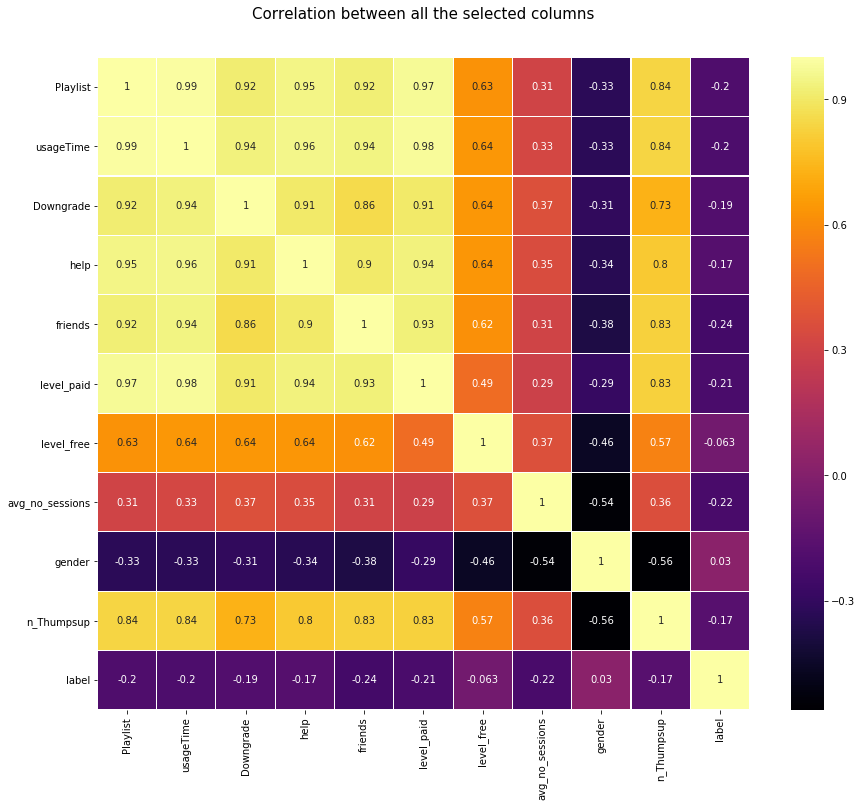

In [32]:
#corrmap = plt.cm.inferno
plt.figure(figsize=(15,12))
plt.title('Correlation between all the selected columns', y=1.05, size=15)
sns.heatmap(selected_feature_table.toPandas().corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.inferno, linecolor='white', annot=True)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.


#### Preparing data and to push to the model Lets use VectorAssembler which is transformer that combines a given list of columns into a single vector column

Here we will going to implement logistic regression and RandomForest classifer and see how these model perform. Since the churned users are a fairly small subset, we using F1 score as the metric to optimize.

In [24]:
#create VectorAssembler to push data to ML models
assembler = VectorAssembler(inputCols=["Playlist","usageTime","Downgrade","help",\
                                       "friends","level_paid","level_free","avg_no_sessions","gender","n_Thumpsup"],\
                            outputCol="inputFeatures")

#Lets normalize data
scaler = Normalizer(inputCol="inputFeatures", outputCol="ScaledFeatures");

In [25]:
#elasticNetParam corresponds to α and regParam corresponds to λ.
model_lr = LogisticRegression(featuresCol="ScaledFeatures", labelCol="label", maxIter=10, regParam=0.01)
model_rf = RandomForestClassifier(featuresCol="ScaledFeatures", labelCol="label")
model_gbt = GBTClassifier(featuresCol="ScaledFeatures", labelCol="label")

In [26]:
#Create Pipeline
pipeline_lr = Pipeline(stages=[assembler, scaler, model_lr]);
pipeline_rf = Pipeline(stages=[assembler, scaler, model_rf]);
pipeline_gbt = Pipeline(stages=[assembler, scaler, model_gbt])

In [27]:
# spilt data for Train and test 
training, test = selected_feature_table.randomSplit([0.8, 0.2]);

In [34]:
training.toPandas().shape


(223106, 12)

In [28]:
#Fit the model
import time

start_time= time.time()

model_lr_fitted = pipeline_lr.fit(training);
model_rf_fitted = pipeline_rf.fit(training);
model_gbt_fitted = pipeline_gbt.fit(training)

end_time= time.time()

print("Total exicute time:{}".format(end_time-start_time))

Total exicute time:1579.7901146411896


In [35]:
#Function which will calcualte Accuracy scores:
def model_performance_accuracy(model, test_data, metric = 'accuracy'):
    """ Calculate Model Scores using f1 metric 
        Input: 
            model- trained model or pipeline object
            metric- the metric used to measure performance
            data - data on which performance measurement should be done
        Output:
            score
    """
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    prediction_result = model.transform(test_data)
    # find f1 score
    score = evaluator.evaluate(prediction_result)
    #return score
    return score

In [36]:
#print both Model Testing F1-Score
print("Logistic Regression Classifier Accuracy:{}".format(model_performance_accuracy(model_lr_fitted, test)));
print("Random Forest  Classifier Accuracy:{}".format(model_performance_accuracy(model_rf_fitted, test)));
print("GBTClassifier  Classifier Accuracy:{}".format(model_performance_accuracy(model_gbt_fitted, test)));

Logistic Regression Classifier Accuracy:0.8430953322074095
Random Forest  Classifier Accuracy:0.9638506593840958
GBTClassifier  Classifier Accuracy:0.9915196377879191


In [37]:
#Function which will calcualte f1 scores:
def model_performance(model, test_data, metric = 'f1'):
    """ Calculate Model Scores using f1 metric 
        Input: 
            model- trained model or pipeline object
            metric- the metric used to measure performance
            data - data on which performance measurement should be done
        Output:
            score
    """
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    prediction_result = model.transform(test_data)
    # find f1 score
    score = evaluator.evaluate(prediction_result)
    #return score
    return score

In [30]:
#print both Model Testing F1-Score
print("Logistic Regression Classifier F1-Score:{}".format(model_performance(model_lr_fitted, test)));
print("Random Forest  Classifier F1-Score:{}".format(model_performance(model_rf_fitted, test)));
print("GBTClassifier  Classifier F1-Score:{}".format(model_performance(model_gbt_fitted, test)));

Logistic Regression Classifier F1-Score:0.7765470592259909
Random Forest  Classifier F1-Score:0.9619697735890758
GBTClassifier  Classifier F1-Score:0.9914322037770119


# Conclusion

###  Summary


In this notebook, i implemented a model to predict customer churn. In the process of Cleaning data, i removed rows with no userId, converted gender to binary numeric column. 10 features were built for our model. We selected 3 models: logistic regression, Random Forest and GBTClassifier to predict churn and finally we selected GBTClassifier as the final model implemented for predicting final result Because of it's good f1 Score. For Preparing data and to push to the model i used VectorAssembler which is transformer that combines a given list of columns into a single vector column. Since the churned users are a fairly small subset, we using F1 score as the metric to optimize.. 

### Reflections from this final project.


This project given exposure to spark environment to analyze a large volume of data that a personal laptop may not be capable to analyze. By identifying customer with high chance to churn prior to the acutal losing, companies are able to use minimal cost to save customers by using targeted messages and offers.

One of the interesting yet difficult things during the project is brainstroming the features that we can derived from the data we have on hand. Developing useful features is crucial to developing a good model, and requires a lot of energy and efforts. Explanatory and exploratory data analysis play important role in this process, Best part is i achived it by using my SQL Query skills.


### To avoid churn in future, the following instrctioned need to be followed.


Once we identified who will be going to churn with Prediction model we can then have to take some action to stopping them to getting churned by

- Running some promotional offers for attracting this targeted users.
- And finding out what is the root cause of those users not liking the Music app and improving those root cases. Ex: like UI changes, Price for the subscription etc... 

### Improvements


The features can be improved a lot after considering more factors, adding more domain knowledges and expertise. Although the volume of data may required tools such as spark to analyze, but we can use more data to have better results as the user base grow.

Currently, we have about 223106 records of unique users, and we only use 80% of them to train. That said, the model has a huge potential to improve if the sample size increase, and the expected performance will also increase.

Since the churned users are a fairly small subset, we using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.